# Gluoncv

## 获取模型参数

生成一个参数字典
net.collect_params()
* 初始化方法1
```
net.collect_params().initialize(mx.init.Normal(sigma=1.), ctx=model_ctx)
```
* 初始化方法2
```
for param in net.collect_params().values():
    if param._data is not None:
        continue
    param.initialize()
```

## gluoncv生成json和params文件
```
net = gcv.model_zoo.get_model('resnet18_v1', pretrained=True)
export_block('resnet18_v1', net, preprocess=True, layout='HWC')

网址如下：
https://gluon-cv.mxnet.io/build/examples_deployment/export_network.html#sphx-glr-build-examples-deployment-export-network-py
```

## Mxnet

* 先定义一个网络net
* 在创建一个module，命名为mod
* bind
* init_params
* init_optimizer
* metric.create
* forward
* update_metric
* backward
* update
在init_optimizer之后，可以使用get_params获得参数arg_params, aux_params = mod.get_params()。由于获得参数是源数据的副本，更改后需要使用set_params进行修改。保存参数使用save_params，保存json文件需要使用mod.save()

In [2]:
import logging
import random
logging.getLogger().setLevel(logging.INFO)

import mxnet as mx
import numpy as np

mx.random.seed(1234)
np.random.seed(1234)
random.seed(1234)

fname = mx.test_utils.download('https://s3.us-east-2.amazonaws.com/mxnet-public/letter_recognition/letter-recognition.data')
data = np.genfromtxt(fname, delimiter=',')[:,1:]
label = np.array([ord(l.split(',')[0])-ord('A') for l in open(fname, 'r')])

batch_size = 32
ntrain = int(data.shape[0]*0.8)
train_iter = mx.io.NDArrayIter(data[:ntrain, :], label[:ntrain], batch_size, shuffle=True)
val_iter = mx.io.NDArrayIter(data[ntrain:, :], label[ntrain:], batch_size)

INFO:root:letter-recognition.data exists, skipping download


<Symbol group [data, fc1_weight, fc1_bias, fc1, relu1, fc2_weight, fc2_bias, fc2, softmax_label, softmax]>


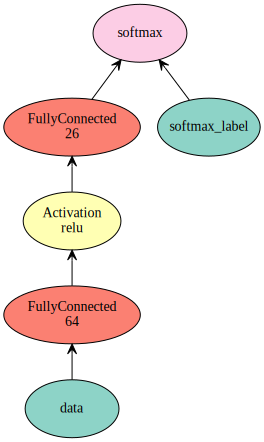

In [4]:
net = mx.sym.Variable('data')
net = mx.sym.FullyConnected(net, name='fc1', num_hidden=64)
net = mx.sym.Activation(net, name='relu1', act_type="relu")
net = mx.sym.FullyConnected(net, name='fc2', num_hidden=26)
net = mx.sym.SoftmaxOutput(net, name='softmax')
print(net.get_internals())
mx.viz.plot_network(net, node_attrs={"shape":"oval","fixedsize":"false"})

In [29]:
mod = mx.mod.Module(symbol=net,
                    context=mx.cpu(),
                    data_names=['data'],
                    label_names=['softmax_label'])

In [46]:
# allocate memory given the input data and label shapes
mod.bind(data_shapes=train_iter.provide_data, label_shapes=train_iter.provide_label)
# initialize parameters by uniform random numbers
mod.init_params(initializer=mx.init.Uniform(scale=.1))
# 获取模型参数并保存
arg_params, aux_params = mod.get_params()
mod.save_params('mxnet.params')
net.save('mxnet.json')
# use SGD with learning rate 0.1 to train
mod.init_optimizer(optimizer='sgd', optimizer_params=(('learning_rate', 0.1), ))
# use accuracy as the metric
metric = mx.metric.create('acc')
# train 5 epochs, i.e. going over the data iter one pass
for epoch in range(5):
    train_iter.reset()
    metric.reset()
    for batch in train_iter:
        mod.forward(batch, is_train=True)       # compute predictions
        mod.update_metric(metric, batch.label)  # accumulate prediction accuracy
        mod.backward()                          # compute gradients
        mod.update()                            # update parameters
    print('Epoch %d, Training %s' % (epoch, metric.get()))

/home/zhangkai/software/anaconda2/envs/mxnet/lib/python3.6/site-packages/ipykernel_launcher.py:4: UserWarning: Parameters already initialized and force_init=False. init_params call ignored.
  after removing the cwd from sys.path.


Epoch 0, Training ('accuracy', 0.8453125)
Epoch 1, Training ('accuracy', 0.8498125)
Epoch 2, Training ('accuracy', 0.85175)
Epoch 3, Training ('accuracy', 0.8505625)
Epoch 4, Training ('accuracy', 0.852625)


In [42]:
aux_params.values()

dict_values([])